## Time Series Forecasting using XGBoost

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
import xgboost as xgb
plt.style.use('fivethirtyeight')

In [2]:
# https://www.youtube.com/watch?v=vV12dGe_Fho

In [17]:
df = pd.read_csv("C:\\Users\\yioko\\Downloads\\Data\\Time Series Forecasting Data from Kaggle\\archive\\PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<AxesSubplot: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

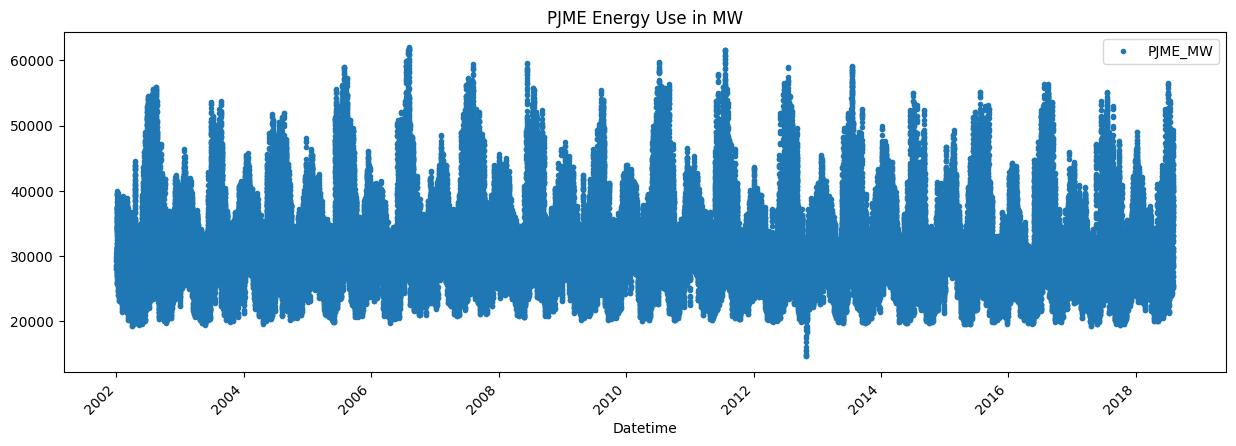

In [18]:
df.plot(figsize = (15,5),
        rot = 45,
       style = '.',
       color = color_pal[0],
       title = 'PJME Energy Use in MW')

## Train / Test Split

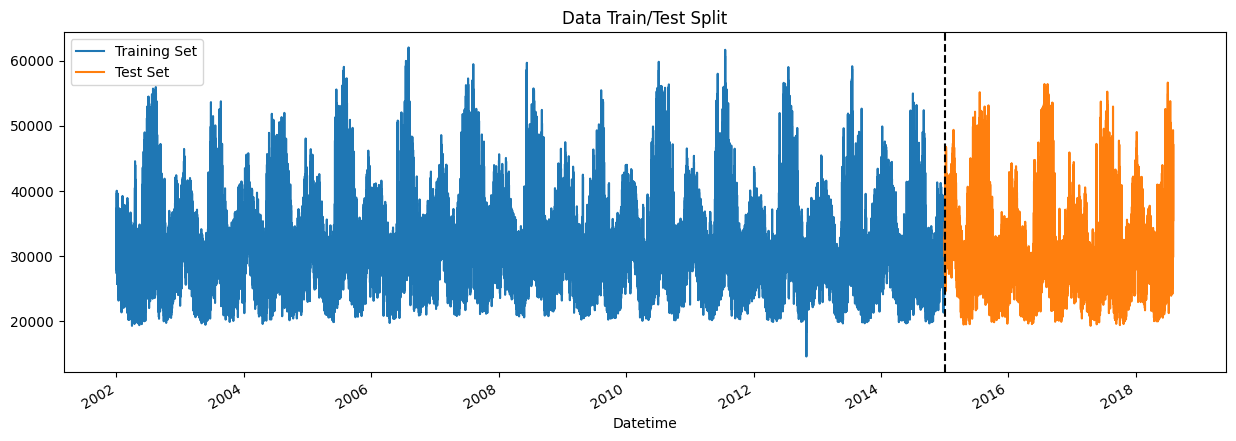

In [27]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color = 'black' , ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<AxesSubplot: xlabel='Datetime'>

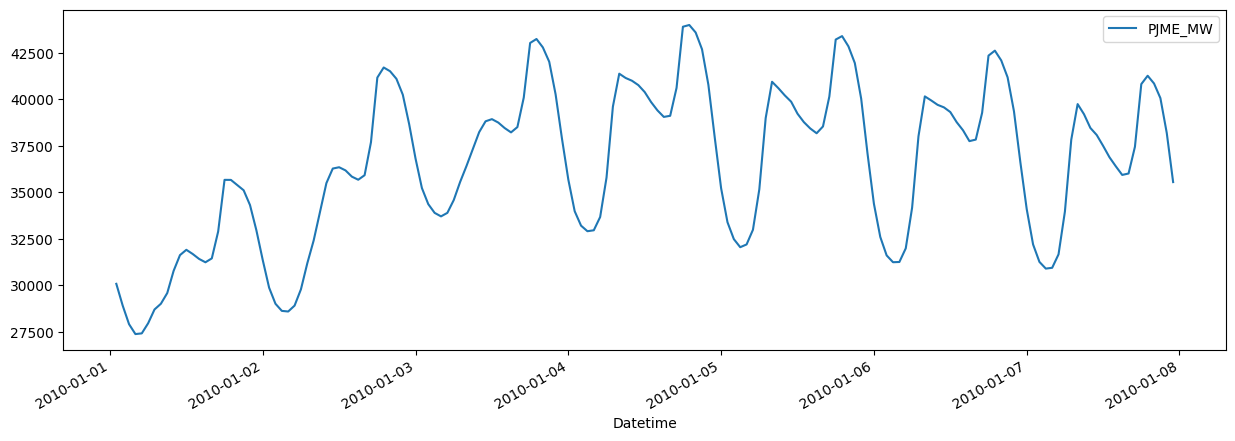

In [30]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5))

## Feature Creation

In [38]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    return df

df = create_features(df)

## Visualize our Feature / Target Realationship

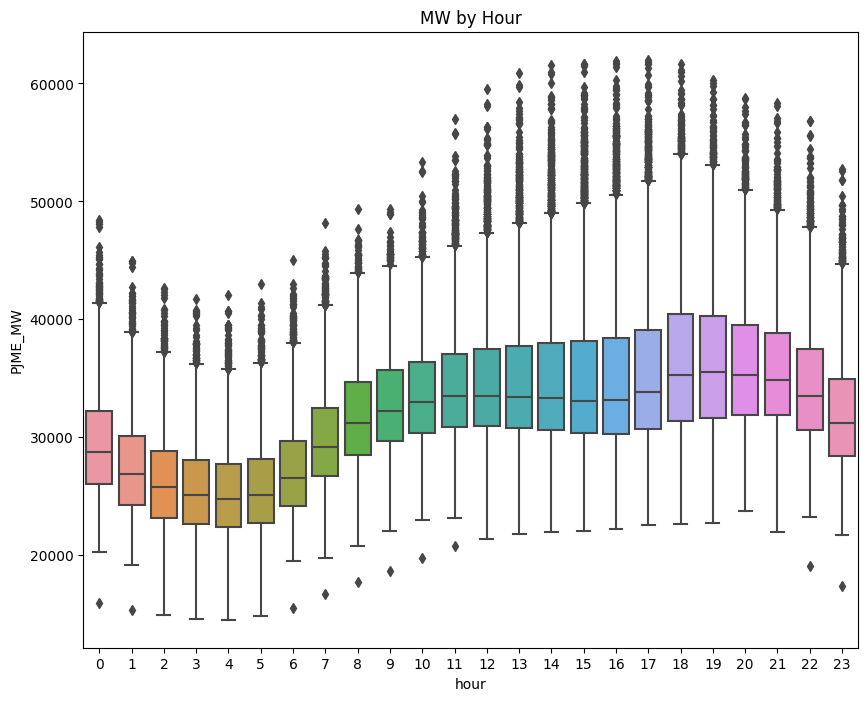

In [34]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

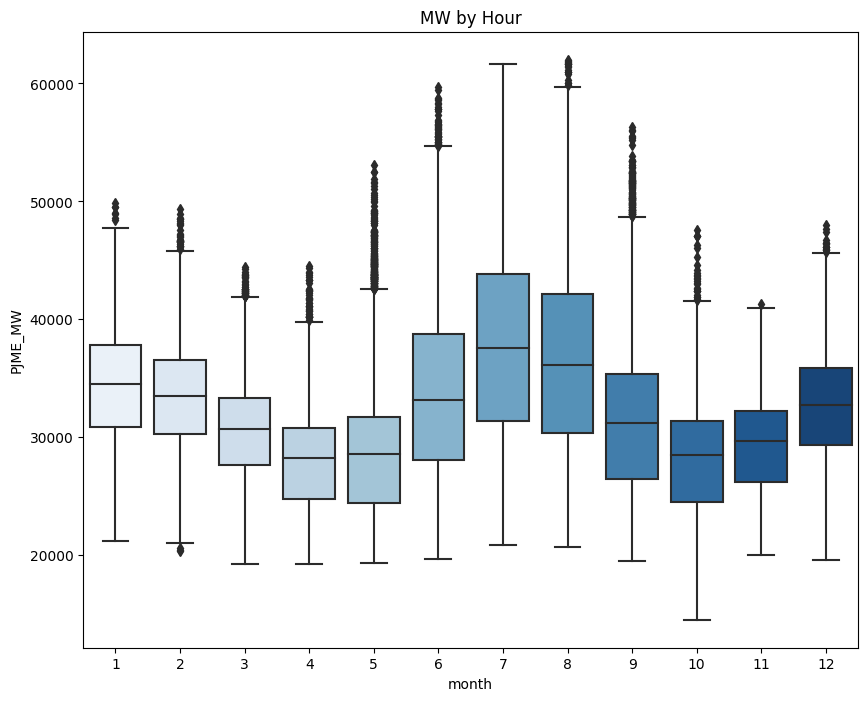

In [36]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Hour')
plt.show()

## Create the Model

In [63]:
train = create_features(train)
test = create_features(test)

In [64]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'day_of_year', 'prediction'],
      dtype='object')

In [65]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'day_of_year']
TARGET = 'PJME_MW'

In [66]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [68]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate = 0.01)
reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [69]:
fi = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns = ['importance'])

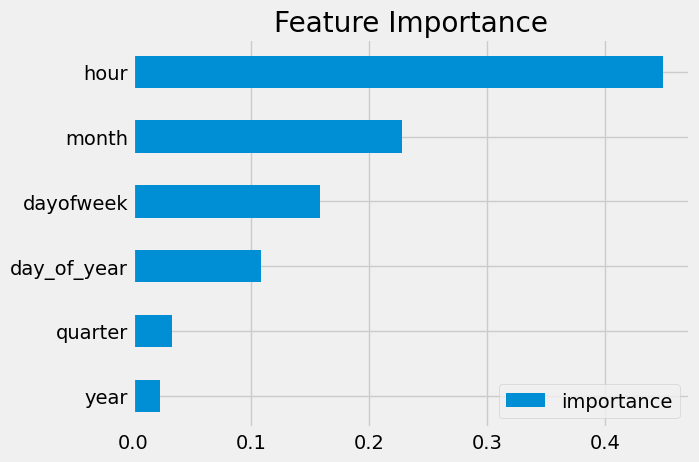

In [70]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

In [73]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

C:\Users\yioko\AppData\Local\Temp\ipykernel_6336\1087370408.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Truth Data', 'Predictions')


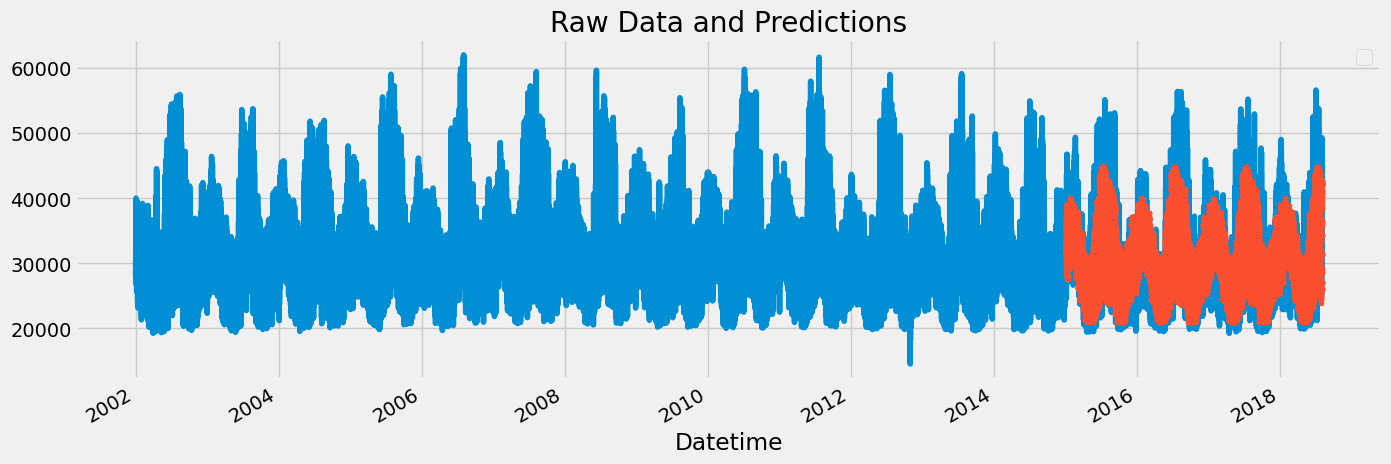

In [74]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax=ax, style = '.')
plt.legend('Truth Data', 'Predictions')
ax.set_title('Raw Data and Predictions')
plt.show()

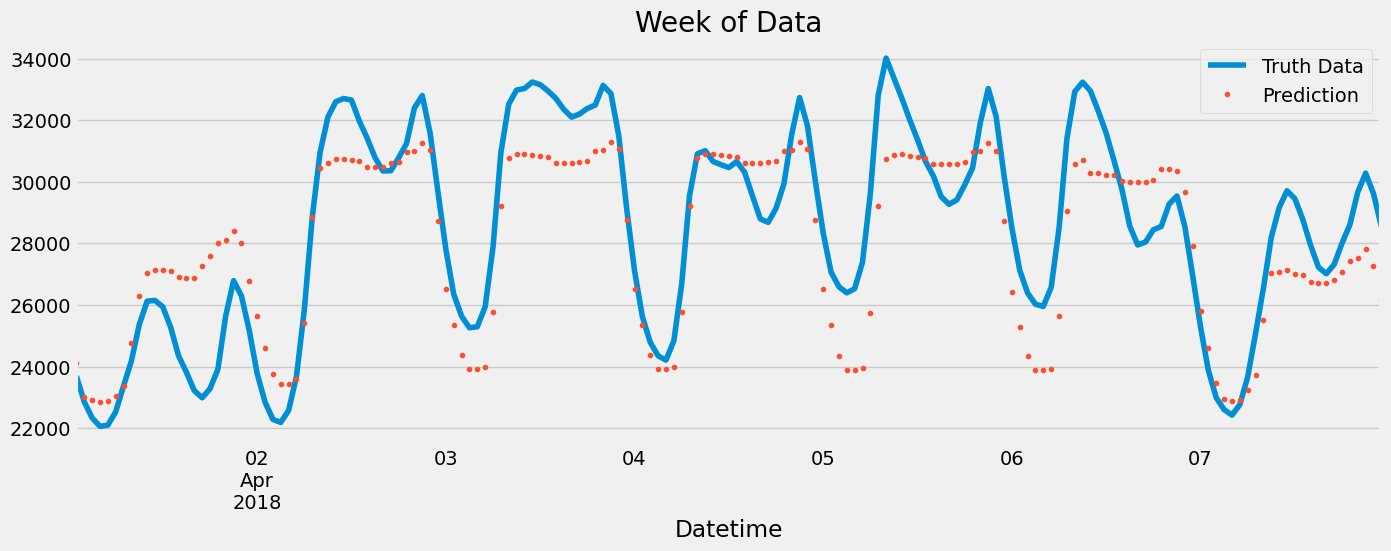

In [75]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15,5), title = 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [76]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 3715.93


## Calculate Error

#### Look at the best and the worst predicted days

In [77]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [78]:
test['date'] = test.index.date

In [80]:
test.groupby('date')['error'].mean().sort_values(ascending = False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

In [81]:
test.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64